In [1]:
# Import Required Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import pyodbc
from datetime import datetime

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster

from joblib import dump, load

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

# ENV Variables
# ==============================================================================
from dotenv import load_dotenv
load_dotenv()

import os

c:\Users\Paul\Documents\Projects-vscode\forecast_02\TRAFIC_FLOW\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_connection_string():
    server = os.getenv('DB_HOST')
    database = os.getenv('DB_NAME')
    username = os.getenv('DB_USER')
    password = os.getenv('DB_PASSWORD')
    driver = '{ODBC Driver 18 for SQL Server}'
        
    return f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password};'

cnn = get_connection_string()

In [3]:
# Funciones generales
# ==============================================================================
def get_blob_to_df(table_name : str, connection_str):
    try:
        with pyodbc.connect(connection_str, autocommit=True) as conn:
            query = f"SELECT * FROM {table_name};"
            df = pd.read_sql(query, conn)

        return (True, df)
    except Exception as e:
        return (False, str(e))

In [86]:
# Query SQL para extraer datos
_, datos = get_blob_to_df(table_name = 'dbo.vw_FACT_TRAFFIC_FLOW_FORECASTING', connection_str = cnn)

In [87]:
datos

,date_time,hour,period,month,weekday,sentido,tipo_vehiculo,forma_pago,traffic_count,TIPO_CONJUNTO
0,2017-01-01 00:00:00,0,AM,1,6,Centro,Liviano,no cobrado,252,1
1,2017-01-01 00:00:00,0,AM,1,6,Centro,Liviano,efectivo,1,1
2,2017-01-01 00:00:00,0,AM,1,6,Centro,Liviano,telepase,100,1
3,2017-01-01 00:00:00,0,AM,1,6,Centro,Pesado,telepase,2,1
4,2017-01-01 00:00:00,0,AM,1,6,Centro,Pesado,telepase,1,1
...,...,...,...,...,...,...,...,...,...,...
1048570,2020-12-29 10:00:00,10,AM,12,1,Provincia,Pesados 6 Ejes,tag,1,1
1048571,2020-12-29 11:00:00,11,AM,12,1,Centro,Pesados 6 Ejes,tag,2,1
1048572,2020-12-29 12:00:00,12,PM,12,1,Provincia,Pesados 6 Ejes,tag,1,1
1048573,2020-12-29 13:00:00,13,PM,12,1,Centro,Pesados 6 Ejes,tag,1,1


In [84]:
# weekday to object
datos['weekday'] = datos['weekday'].astype('object')
datos['hour'] = datos['hour'].astype('object')

In [89]:
datos_grouped_by_datetime = datos.groupby(['date_time', 'weekday', 'hour']).agg({'traffic_count': 'sum'}).reset_index()

In [90]:
# Preprocesamiento de datos
# ==============================================================================
# Convertir las columnas 'fecha' y 'hora_inicio' a objetos date_time
datos_grouped_by_datetime['date_time'] = pd.to_datetime(datos_grouped_by_datetime['date_time'], format='%Y-%m-%d %H:%M:%S')

# Establecer 'date_time' como índice del DataFrame
datos_grouped_by_datetime = datos_grouped_by_datetime.set_index('date_time')

In [91]:
# Ajustar la frecuencia del DataFrame a intervalos horarios
datos_grouped_by_datetime = datos_grouped_by_datetime.asfreq('H')

# Ordenar el DataFrame por el índice (date_time)
datos_grouped_by_datetime = datos_grouped_by_datetime.sort_index()

In [92]:
datos_grouped_by_datetime

,weekday,hour,traffic_count
date_time,,,
2017-01-01 00:00:00,6.0,0.0,598.0
2017-01-01 01:00:00,6.0,1.0,2222.0
2017-01-01 02:00:00,6.0,2.0,2632.0
2017-01-01 03:00:00,6.0,3.0,1780.0
2017-01-01 04:00:00,6.0,4.0,794.0
...,...,...,...
2020-12-31 19:00:00,3.0,19.0,2602.0
2020-12-31 20:00:00,3.0,20.0,2830.0
2020-12-31 21:00:00,3.0,21.0,1865.0


In [93]:
datos = datos_grouped_by_datetime

Los datos empleados en este documento corresponden al registro del tránsito vehicular en varias estaciones de la ciudad durante el año 2017. El dataset incluye información sobre el número de vehículos que pasaron por cada estación, junto con detalles como el tipo de vehículo, el método de pago utilizado, y la dirección del flujo vehicular.

In [98]:
# Separación datos train-val-test
# ==============================================================================
fin_train = '2019-06-30 23:59:00'
fin_validacion = '2020-06-30 23:59:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2017-01-01 00:00:00 --- 2019-06-30 23:00:00  (n=21864)
Fechas validacion : 2019-07-01 00:00:00 --- 2020-06-30 23:00:00  (n=8784)
Fechas test       : 2020-07-01 00:00:00 --- 2020-12-31 23:00:00  (n=4416)


In [11]:
print(datos_train.shape)
print(datos_val.shape)
print(datos_test.shape)

(21864, 1)
(8784, 1)
(4416, 1)


In [12]:
print(datos_train['traffic_count'].dtype)
print(datos_val['traffic_count'].dtype)
print(datos_test['traffic_count'].dtype)

float64
float64
float64


In [95]:
# Contar nulos
print(f"Datos train nulos: {datos_train.isnull().sum()}")
print(f"Datos validacion nulos: {datos_val.isnull().sum()}") 
print(f"Datos test nulos: {datos_test.isnull().sum()}")

Datos train nulos: weekday          11
hour             11
traffic_count    11
dtype: int64
Datos validacion nulos: weekday          0
hour             0
traffic_count    0
dtype: int64
Datos test nulos: weekday          0
hour             0
traffic_count    0
dtype: int64


In [16]:
# Mostrar registros con nulos
print("Datos train con nulos:")
print(datos_train[datos_train.isnull().any(axis=1)])
print("Datos validacion con nulos:")
print(datos_val[datos_val.isnull().any(axis=1)])
print("Datos test con nulos:")
print(datos_test[datos_test.isnull().any(axis=1)])

Datos train con nulos:
                     traffic_count
date_time                         
2018-11-29 22:00:00            NaN
2018-11-29 23:00:00            NaN
2018-11-30 00:00:00            NaN
2018-11-30 01:00:00            NaN
2018-11-30 02:00:00            NaN
2018-11-30 03:00:00            NaN
2018-11-30 04:00:00            NaN
2018-11-30 05:00:00            NaN
2018-11-30 06:00:00            NaN
2018-12-01 03:00:00            NaN
2018-12-30 07:00:00            NaN
Datos validacion con nulos:
Empty DataFrame
Columns: [traffic_count]
Index: []
Datos test con nulos:
Empty DataFrame
Columns: [traffic_count]
Index: []


In [99]:
datos_train['traffic_count'] = datos_train['traffic_count'].fillna(
    datos_train.groupby([datos_train.index.hour])['traffic_count'].transform('mean')
)

In [102]:
datos_train['weekday'] = datos_train['weekday'].fillna(
    datos_train.groupby([datos_train.index.hour])['weekday'].transform('mean')
)

In [103]:
datos_train['hour'] = datos_train['hour'].fillna(
    datos_train.groupby([datos_train.index.hour])['hour'].transform('mean')
)

In [104]:
print(f"Datos train nulos: {datos_train.isnull().sum()}")

Datos train nulos: weekday          0
hour             0
traffic_count    0
dtype: int64


In [70]:
datos_train = None

## Representación de la serie temporal

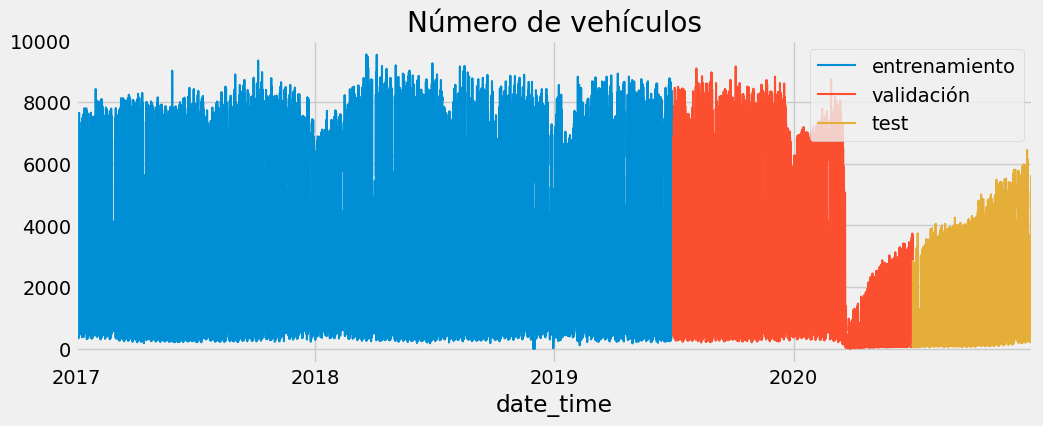

In [105]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
datos_train['traffic_count'].plot(ax=ax, label='entrenamiento')
datos_val['traffic_count'].plot(ax=ax, label='validación')
datos_test['traffic_count'].plot(ax=ax, label='test')
ax.set_title('Número de vehículos')
ax.legend();

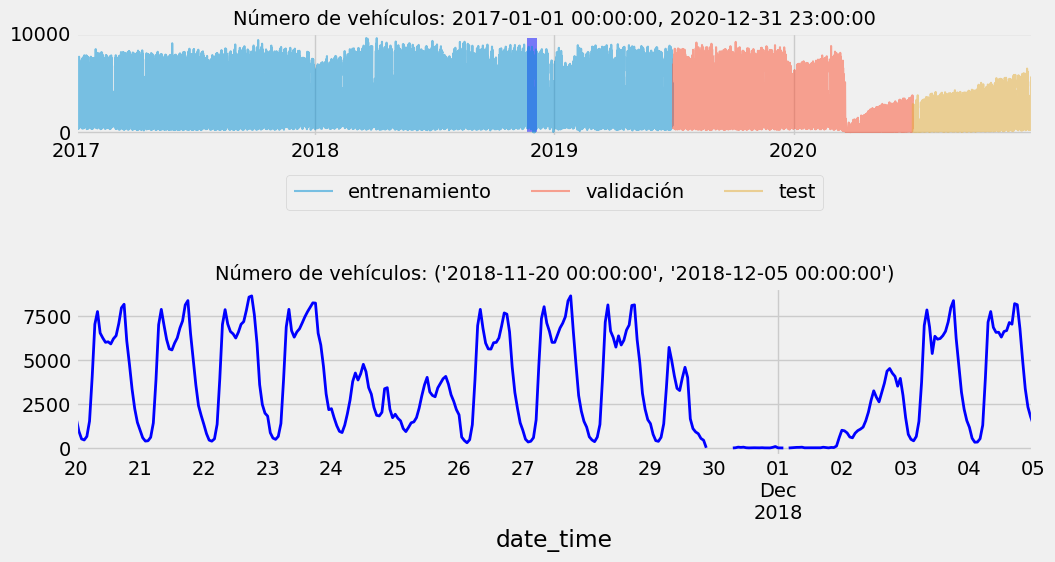

In [106]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2018-11-20 00:00:00','2018-12-05 00:00:00')

fig = plt.figure(figsize=(11, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos_train['traffic_count'].plot(ax=main_ax, label='entrenamiento', alpha=0.5)
datos_val['traffic_count'].plot(ax=main_ax, label='validación', alpha=0.5)
datos_test['traffic_count'].plot(ax=main_ax, label='test', alpha=0.5)
min_y = min(datos['traffic_count'])
max_y = max(datos['traffic_count'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))

datos.loc[zoom[0]: zoom[1]]['traffic_count'].plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Número de vehículos: {datos.index.min()}, {datos.index.max()}', fontsize=14)
zoom_ax.set_title(f'Número de vehículos: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

In [107]:
# Gráfico interactivo serie temporal
# ==============================================================================
datos.loc[:fin_train, 'particion'] = 'entrenamiento'
datos.loc[fin_train:fin_validacion, 'particion'] = 'validación'
datos.loc[fin_validacion:, 'particion'] = 'test'

fig = px.line(
    data_frame = datos.reset_index(),
    x      = 'date_time',
    y      = 'traffic_count',
    color  = 'particion',
    title  = 'Número de vehículos',
    width  = 900,
    height = 500
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

datos=datos.drop(columns='particion')

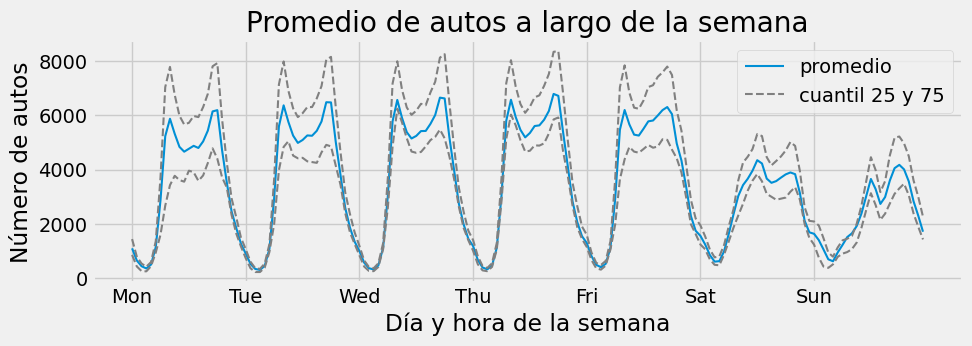

In [108]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
promedio_dia_hora = datos.groupby(["weekday", "hour"])["traffic_count"].mean()
q25_dia_hora = datos.groupby(["weekday", "hour"])["traffic_count"].quantile(0.25)
q75_dia_hora = datos.groupby(["weekday", "hour"])["traffic_count"].quantile(0.75)

promedio_dia_hora.plot(ax=ax, label='promedio')
q25_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='')
q75_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='cuantil 25 y 75')


ax.set(
    title="Promedio de autos a largo de la semana",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel="Día y hora de la semana",
    ylabel="Número de autos"
)

ax.legend();

## Gráficos de autocorrelación

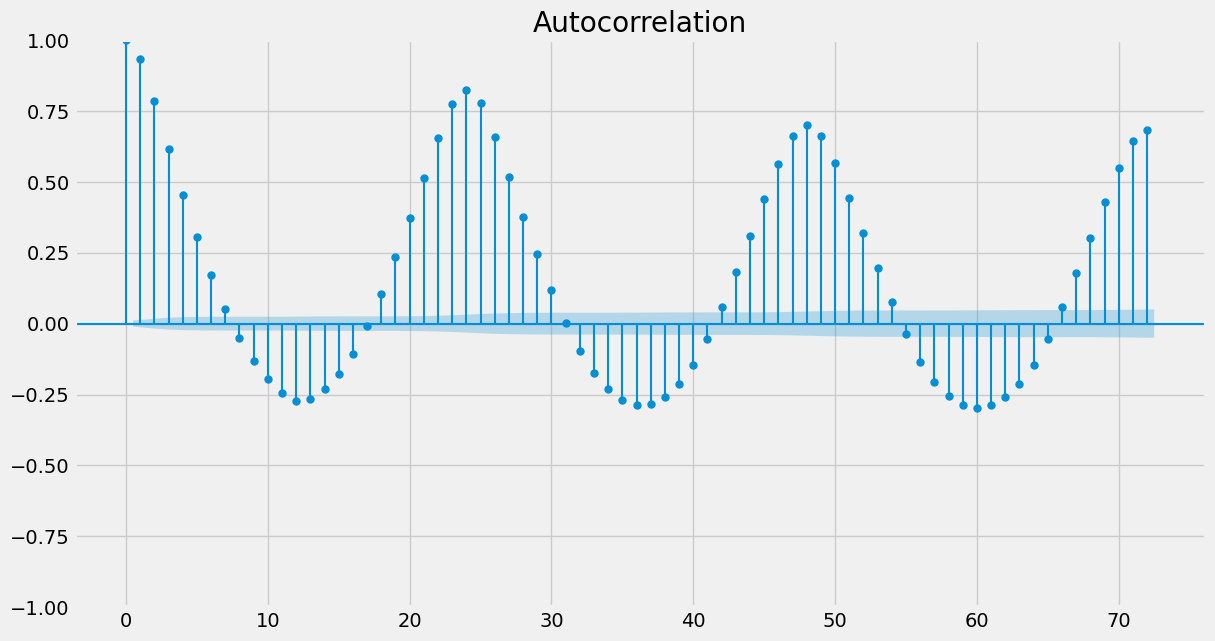

In [110]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(13, 7))
plot_acf(
  datos['traffic_count'].fillna(
    datos.groupby([datos.index.hour])['traffic_count'].transform('mean')
  )  # Rellenar nulos hacia adelante
  , ax=ax
  , lags=72
  )
#plot_acf(data_a, lags=90)
plt.show()

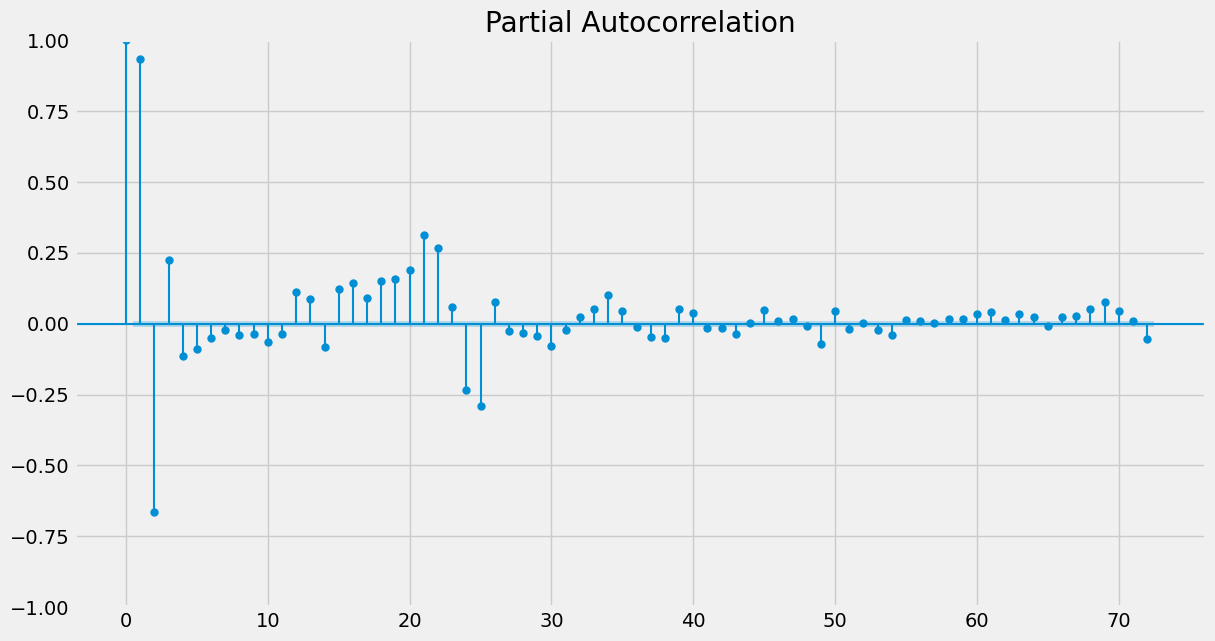

In [111]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(13, 7))
plot_pacf(
  datos['traffic_count'].fillna(
    datos.groupby([datos.index.hour])['traffic_count'].transform('mean')
  ) 
  , ax=ax, lags=72
  , method='ywm'
)
plt.show()

## XGBoost
XGBoost, acrónimo de Extreme Gradient Boosting es una implementación muy eficiente del algoritmo de stochastic gradient boosting que se ha convertido en un referente dentro del ámbito de machine learning. Además de su propia API, la librería XGBoost incluye la clase XGBRegressor que sigue la API de scikit learn y, por lo tanto, es compatible con skforecast.

Como primera aproximación se utiliza un modelo autorregresivo que utiliza como predictores valores pasados (lags) de la propia variable respuesta. Dada la elevada cantidad de hiperparámetros que tienen los modelos de gradient boosting, se emplea una estrategia de gridsearch combinada con backtesting para identificar la configuración con la que se obtienen mejores predicciones.

In [112]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogen

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}



# Rellenar valores nulos con el promedio por hora
datos.loc[:fin_validacion, 'traffic_count'] = datos.loc[:fin_validacion, 'traffic_count'].fillna(
    datos.loc[:fin_validacion, 'traffic_count'].groupby(datos.loc[:fin_validacion].index.hour).transform('mean')
)



Number of models compared: 36.


lags grid: 100%|██████████| 3/3 [03:26<00:00, 68.70s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 1595026.3208495907



In [117]:
# Lags utilizados como predictores
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

# Grid search de hiperparámetros
resultados_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = datos.loc[:fin_validacion, 'traffic_count'], # conjunto de train y validación
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 36,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(datos_train)), # El modelo se entrena con los datos de entrenamiento
        return_best        = True,
        verbose            = False
)

Number of models compared: 48.


lags grid: 100%|██████████| 4/4 [04:11<00:00, 62.83s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 1595026.3208495907



# Resultados Grid Search
# ==============================================================================
resultados_grid

## Backtesting periodo de test

In [118]:
len(datos.loc[:fin_validacion])

30648

In [119]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos['traffic_count'],
    initial_train_size = len(datos.loc[:fin_validacion]),
    steps      = 60,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
)

print(f"Error de backtest: {metric}")

100%|██████████| 74/74 [00:01<00:00, 40.16it/s]

Error de backtest:    mean_squared_error
0        1.793159e+06


In [120]:
predicciones

,pred
2020-07-01 00:00:00,198.893967
2020-07-01 01:00:00,183.783417
2020-07-01 02:00:00,197.332901
2020-07-01 03:00:00,215.595230
2020-07-01 04:00:00,291.404602
...,...
2020-12-31 19:00:00,4568.401855
2020-12-31 20:00:00,3420.754639
2020-12-31 21:00:00,2610.554932
2020-12-31 22:00:00,1852.870605


In [127]:
# Save predicciones test
# ==============================================================================
def guardar_resultados(datos, modelo):
    fecha_ejecucion = datetime.now()
    resultados = pd.DataFrame({
        'DATE_TIME': datos.index,
        'PREDICCION': datos['pred'],
        'MODELO': modelo,
        'EXECUTION_DATE': fecha_ejecucion
    })
    return resultados

def upload_df_to_blob(df: pd.DataFrame, table_name: str, connection_str: str):
    try:
        df = df.where(pd.notnull(df), None)
        with pyodbc.connect(connection_str, autocommit=True) as conn:
            cursor = conn.cursor()
            columns = ','.join(df.columns)
            cmd_insert = f"INSERT INTO {table_name} ({columns}) VALUES ({','.join(['?'] * len(df.columns))})"
            cursor.fast_executemany = True
            cursor.executemany(cmd_insert, df.values.tolist())
        return True, ""
    except Exception as e:
        return False, str(e)

def guardar_pronostico(datos, modelo):
    # Obtener la fecha de ejecución actual
    fecha_ejecucion = datetime.now()
    
    # Crear un nuevo DataFrame con las columnas requeridas
    resultados = pd.DataFrame({
        'DATE_TIME': datos.index,        # Fecha (index)
        'PREDICCION': datos['pred'],       # Columna pred
        'MODELO': modelo            # Nombre del modelo
    })
    
    return resultados

In [124]:
# Save predicciones test
# ==============================================================================
rs1 = guardar_resultados(predicciones, 'MODEL_FORECASTER')
upload_df_to_blob(df = rs1, table_name = 'PREDICCION_TRAFFIC_FLOW', connection_str = cnn)

(True, '')

In [125]:
forecaster.fit(y=datos_train['traffic_count'])

In [126]:
data1 = forecaster.predict(steps=2160, last_window=datos['traffic_count'])
data1 = pd.DataFrame(data1)
data1

,pred
2021-01-01 00:00:00,464.522827
2021-01-01 01:00:00,713.651184
2021-01-01 02:00:00,824.502319
2021-01-01 03:00:00,1110.163940
2021-01-01 04:00:00,1246.606445
...,...
2021-03-31 19:00:00,824.940308
2021-03-31 20:00:00,747.284180
2021-03-31 21:00:00,704.846619
2021-03-31 22:00:00,660.647217


In [128]:
# Save forecasting
# ==============================================================================
rs1 = guardar_pronostico(data1, 'MODEL_FORECASTER')
upload_df_to_blob(df = rs1, table_name = 'FORECASTING_TRAFFIC_FLOW', connection_str = cnn)

(True, '')

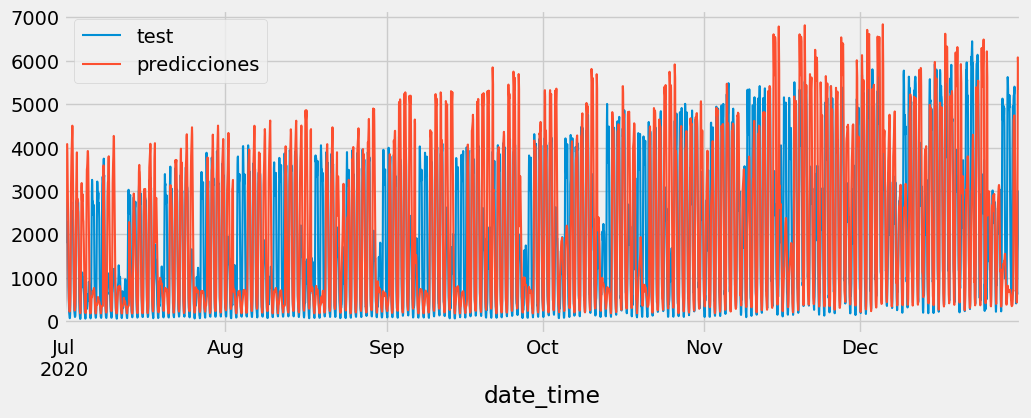

In [129]:
# Gráfico estatico predicciones test
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
datos_test['traffic_count'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.legend();

In [130]:
# Gráfico interactivo serie temporal
# ==============================================================================
datos_plot = pd.DataFrame({
                'test': datos_test['traffic_count'],
                'prediccion': predicciones['pred'],

                 })
datos_plot.index.name = 'date_time'

fig = px.line(
    data_frame = datos_plot.reset_index(),
    x      = 'date_time',
    y      = datos_plot.columns,
    title  = 'Número de autos: test vs predicciones',
    width  = 900,
    height = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()